本笔记希望复现 huang gao 组的 budgeted training of vision transformers。我们基于已有的 train.py 进行修改，别的都基本不动。之前在 deit 上改了一个基于 transformer 做变动的版本，想了想觉得不好，现在新做一个。

首先我们拿一个训练过程中的 transformer 的 model 看一下，需要搞清楚它的结构，才好进行修改。

下面是必要的头文件和一些 args 的处理。

In [1]:
#!/usr/bin/env python3
""" ImageNet Training Script

This is intended to be a lean and easily modifiable ImageNet training script that reproduces ImageNet
training results with some of the latest networks and training techniques. It favours canonical PyTorch
and standard Python style over trying to be able to 'do it all.' That said, it offers quite a few speed
and training result improvements over the usual PyTorch example scripts. Repurpose as you see fit.

This script was started from an early version of the PyTorch ImageNet example
(https://github.com/pytorch/examples/tree/master/imagenet)

NVIDIA CUDA specific speedups adopted from NVIDIA Apex examples
(https://github.com/NVIDIA/apex/tree/master/examples/imagenet)

Hacked together by / Copyright 2020 Ross Wightman (https://github.com/rwightman)
"""

"""
ADDITIONAL NOTES BY fish:
    - This script is a modified version of the original train.py script from Ross Wightman's timm library.
    - for the current version, the 
"""

import argparse
import logging
import os
import time
from collections import OrderedDict
from contextlib import suppress
from datetime import datetime
from functools import partial

import torch
import torch.nn as nn
import torchvision.utils
import yaml
from torch.nn.parallel import DistributedDataParallel as NativeDDP

from timm import utils
from timm.data import create_dataset, create_loader, resolve_data_config, Mixup, FastCollateMixup, AugMixDataset
from timm.layers import convert_splitbn_model, convert_sync_batchnorm, set_fast_norm
from timm.loss import JsdCrossEntropy, SoftTargetCrossEntropy, BinaryCrossEntropy, LabelSmoothingCrossEntropy
from timm.models import create_model, safe_model_name, resume_checkpoint, load_checkpoint, model_parameters
from timm.optim import create_optimizer_v2, optimizer_kwargs
from timm.scheduler import create_scheduler_v2, scheduler_kwargs
from timm.utils import ApexScaler, NativeScaler

try:
    from apex import amp
    from apex.parallel import DistributedDataParallel as ApexDDP
    from apex.parallel import convert_syncbn_model
    has_apex = True
except ImportError:
    has_apex = False

has_native_amp = False
try:
    if getattr(torch.cuda.amp, 'autocast') is not None:
        has_native_amp = True
except AttributeError:
    pass

try:
    import wandb
    has_wandb = True
except ImportError:
    has_wandb = False

try:
    from functorch.compile import memory_efficient_fusion
    has_functorch = True
except ImportError as e:
    has_functorch = False

# fish: secondorder
from eva import KFAC as Eva
from eva import KFACParamScheduler

has_compile = hasattr(torch, 'compile')


_logger = logging.getLogger('train')

# The first arg parser parses out only the --config argument, this argument is used to
# load a yaml file containing key-values that override the defaults for the main parser below
config_parser = parser = argparse.ArgumentParser(description='Training Config', add_help=False)
parser.add_argument('-c', '--config', default='', type=str, metavar='FILE',
                    help='YAML config file specifying default arguments')


parser = argparse.ArgumentParser(description='PyTorch ImageNet Training')

# Dataset parameters
group = parser.add_argument_group('Dataset parameters')
# Keep this argument outside the dataset group because it is positional.
parser.add_argument('data', nargs='?', metavar='DIR', const=None,
                    help='path to dataset (positional is *deprecated*, use --data-dir)')
parser.add_argument('--data-dir', metavar='DIR',
                    help='path to dataset (root dir)')
parser.add_argument('--dataset', metavar='NAME', default='',
                    help='dataset type + name ("<type>/<name>") (default: ImageFolder or ImageTar if empty)')
group.add_argument('--train-split', metavar='NAME', default='train',
                   help='dataset train split (default: train)')
group.add_argument('--val-split', metavar='NAME', default='validation',
                   help='dataset validation split (default: validation)')
group.add_argument('--dataset-download', action='store_true', default=False,
                   help='Allow download of dataset for torch/ and tfds/ datasets that support it.')
group.add_argument('--class-map', default='', type=str, metavar='FILENAME',
                   help='path to class to idx mapping file (default: "")')

# Model parameters
group = parser.add_argument_group('Model parameters')
group.add_argument('--model', default='resnet50', type=str, metavar='MODEL',
                   help='Name of model to train (default: "resnet50")')
group.add_argument('--pretrained', action='store_true', default=False,
                   help='Start with pretrained version of specified network (if avail)')
group.add_argument('--initial-checkpoint', default='', type=str, metavar='PATH',
                   help='Initialize model from this checkpoint (default: none)')
group.add_argument('--resume', default='', type=str, metavar='PATH',
                   help='Resume full model and optimizer state from checkpoint (default: none)')
group.add_argument('--no-resume-opt', action='store_true', default=False,
                   help='prevent resume of optimizer state when resuming model')
group.add_argument('--num-classes', type=int, default=None, metavar='N',
                   help='number of label classes (Model default if None)')
group.add_argument('--gp', default=None, type=str, metavar='POOL',
                   help='Global pool type, one of (fast, avg, max, avgmax, avgmaxc). Model default if None.')
group.add_argument('--img-size', type=int, default=None, metavar='N',
                   help='Image size (default: None => model default)')
group.add_argument('--in-chans', type=int, default=None, metavar='N',
                   help='Image input channels (default: None => 3)')
group.add_argument('--input-size', default=None, nargs=3, type=int,
                   metavar='N N N',
                   help='Input all image dimensions (d h w, e.g. --input-size 3 224 224), uses model default if empty')
group.add_argument('--crop-pct', default=None, type=float,
                   metavar='N', help='Input image center crop percent (for validation only)')
group.add_argument('--mean', type=float, nargs='+', default=None, metavar='MEAN',
                   help='Override mean pixel value of dataset')
group.add_argument('--std', type=float, nargs='+', default=None, metavar='STD',
                   help='Override std deviation of dataset')
group.add_argument('--interpolation', default='', type=str, metavar='NAME',
                   help='Image resize interpolation type (overrides model)')
group.add_argument('-b', '--batch-size', type=int, default=128, metavar='N',
                   help='Input batch size for training (default: 128)')
group.add_argument('-vb', '--validation-batch-size', type=int, default=None, metavar='N',
                   help='Validation batch size override (default: None)')
group.add_argument('--channels-last', action='store_true', default=False,
                   help='Use channels_last memory layout')
group.add_argument('--fuser', default='', type=str,
                   help="Select jit fuser. One of ('', 'te', 'old', 'nvfuser')")
group.add_argument('--grad-accum-steps', type=int, default=1, metavar='N',
                   help='The number of steps to accumulate gradients (default: 1)')
group.add_argument('--grad-checkpointing', action='store_true', default=False,
                   help='Enable gradient checkpointing through model blocks/stages')
group.add_argument('--fast-norm', default=False, action='store_true',
                   help='enable experimental fast-norm')
group.add_argument('--model-kwargs', nargs='*', default={}, action=utils.ParseKwargs)
group.add_argument('--head-init-scale', default=None, type=float,
                   help='Head initialization scale')
group.add_argument('--head-init-bias', default=None, type=float,
                   help='Head initialization bias value')

# scripting / codegen
scripting_group = group.add_mutually_exclusive_group()
scripting_group.add_argument('--torchscript', dest='torchscript', action='store_true',
                             help='torch.jit.script the full model')
scripting_group.add_argument('--torchcompile', nargs='?', type=str, default=None, const='inductor',
                             help="Enable compilation w/ specified backend (default: inductor).")

# Optimizer parameters
group = parser.add_argument_group('Optimizer parameters')
group.add_argument('--opt', default='sgd', type=str, metavar='OPTIMIZER',
                   help='Optimizer (default: "sgd")')
group.add_argument('--opt-eps', default=None, type=float, metavar='EPSILON',
                   help='Optimizer Epsilon (default: None, use opt default)')
group.add_argument('--opt-betas', default=None, type=float, nargs='+', metavar='BETA',
                   help='Optimizer Betas (default: None, use opt default)')
group.add_argument('--momentum', type=float, default=0.9, metavar='M',
                   help='Optimizer momentum (default: 0.9)')
group.add_argument('--weight-decay', type=float, default=2e-5,
                   help='weight decay (default: 2e-5)')
group.add_argument('--clip-grad', type=float, default=None, metavar='NORM',
                   help='Clip gradient norm (default: None, no clipping)')
group.add_argument('--clip-mode', type=str, default='norm',
                   help='Gradient clipping mode. One of ("norm", "value", "agc")')
group.add_argument('--layer-decay', type=float, default=None,
                   help='layer-wise learning rate decay (default: None)')
group.add_argument('--opt-kwargs', nargs='*', default={}, action=utils.ParseKwargs)

# fish: EVA preconditioner parameters
group = parser.add_argument_group('Preconditioner parameters')

# eva second conditioner arguments
parser.add_argument('--use-eva', action='store_true',default=False,help='use Eva preconditioner')

# KFAC Parameters
# parser.add_argument('--kfac-name', type=str, default='inverse',
#         help='choises: %s' % kfac.kfac_mappers.keys() + ', default: '+'inverse')
parser.add_argument('--exclude-parts', type=str, default='',
        help='choises: CommunicateInverse,ComputeInverse,CommunicateFactor,ComputeFactor')
parser.add_argument('--kfac-update-freq', type=int, default=1,
                    help='iters between kfac inv ops (0 = no kfac) (default: 1)')
parser.add_argument('--kfac-cov-update-freq', type=int, default=1,
                    help='iters between kfac cov ops (default: 1)')
parser.add_argument('--kfac-update-freq-alpha', type=float, default=10,
                    help='KFAC update freq multiplier (default: 10)')
parser.add_argument('--kfac-update-freq-decay', nargs='+', type=int, default=None,
                    help='KFAC update freq schedule (default None)')
parser.add_argument('--stat-decay', type=float, default=0.95,
                    help='Alpha value for covariance accumulation (default: 0.95)')
parser.add_argument('--damping', type=float, default=0.001,
                    help='KFAC damping factor (default 0.001)')
parser.add_argument('--damping-alpha', type=float, default=0.5,
                    help='KFAC damping decay factor (default: 0.5)')
parser.add_argument('--damping-decay', nargs='+', type=int, default=None,
                    help='KFAC damping decay schedule (default None)')
parser.add_argument('--kl-clip', type=float, default=0.001,
                    help='KL clip (default: 0.001)')
parser.add_argument('--diag-blocks', type=int, default=1,
                    help='Number of blocks to approx layer factor with (default: 1)')
parser.add_argument('--diag-warmup', type=int, default=0,
                    help='Epoch to start diag block approximation at (default: 0)')
parser.add_argument('--distribute-layer-factors', action='store_true', default=None,
                    help='Compute A and G for a single layer on different workers. '
                            'None to determine automatically based on worker and '
                            'layer count.')


# Learning rate schedule parameters
group = parser.add_argument_group('Learning rate schedule parameters')
group.add_argument('--sched', type=str, default='cosine', metavar='SCHEDULER',
                   help='LR scheduler (default: "step"')
group.add_argument('--sched-on-updates', action='store_true', default=False,
                   help='Apply LR scheduler step on update instead of epoch end.')
group.add_argument('--lr', type=float, default=None, metavar='LR',
                   help='learning rate, overrides lr-base if set (default: None)')
group.add_argument('--lr-base', type=float, default=0.1, metavar='LR',
                   help='base learning rate: lr = lr_base * global_batch_size / base_size')
group.add_argument('--lr-base-size', type=int, default=256, metavar='DIV',
                   help='base learning rate batch size (divisor, default: 256).')
group.add_argument('--lr-base-scale', type=str, default='', metavar='SCALE',
                   help='base learning rate vs batch_size scaling ("linear", "sqrt", based on opt if empty)')
group.add_argument('--lr-noise', type=float, nargs='+', default=None, metavar='pct, pct',
                   help='learning rate noise on/off epoch percentages')
group.add_argument('--lr-noise-pct', type=float, default=0.67, metavar='PERCENT',
                   help='learning rate noise limit percent (default: 0.67)')
group.add_argument('--lr-noise-std', type=float, default=1.0, metavar='STDDEV',
                   help='learning rate noise std-dev (default: 1.0)')
group.add_argument('--lr-cycle-mul', type=float, default=1.0, metavar='MULT',
                   help='learning rate cycle len multiplier (default: 1.0)')
group.add_argument('--lr-cycle-decay', type=float, default=0.5, metavar='MULT',
                   help='amount to decay each learning rate cycle (default: 0.5)')
group.add_argument('--lr-cycle-limit', type=int, default=1, metavar='N',
                   help='learning rate cycle limit, cycles enabled if > 1')
group.add_argument('--lr-k-decay', type=float, default=1.0,
                   help='learning rate k-decay for cosine/poly (default: 1.0)')
group.add_argument('--warmup-lr', type=float, default=1e-5, metavar='LR',
                   help='warmup learning rate (default: 1e-5)')
group.add_argument('--min-lr', type=float, default=0, metavar='LR',
                   help='lower lr bound for cyclic schedulers that hit 0 (default: 0)')
group.add_argument('--epochs', type=int, default=300, metavar='N',
                   help='number of epochs to train (default: 300)')
group.add_argument('--epoch-repeats', type=float, default=0., metavar='N',
                   help='epoch repeat multiplier (number of times to repeat dataset epoch per train epoch).')
group.add_argument('--start-epoch', default=None, type=int, metavar='N',
                   help='manual epoch number (useful on restarts)')
group.add_argument('--decay-milestones', default=[90, 180, 270], type=int, nargs='+', metavar="MILESTONES",
                   help='list of decay epoch indices for multistep lr. must be increasing')
group.add_argument('--decay-epochs', type=float, default=90, metavar='N',
                   help='epoch interval to decay LR')
group.add_argument('--warmup-epochs', type=int, default=5, metavar='N',
                   help='epochs to warmup LR, if scheduler supports')
group.add_argument('--warmup-prefix', action='store_true', default=False,
                   help='Exclude warmup period from decay schedule.'),
group.add_argument('--cooldown-epochs', type=int, default=0, metavar='N',
                   help='epochs to cooldown LR at min_lr, after cyclic schedule ends')
group.add_argument('--patience-epochs', type=int, default=10, metavar='N',
                   help='patience epochs for Plateau LR scheduler (default: 10)')
group.add_argument('--decay-rate', '--dr', type=float, default=0.1, metavar='RATE',
                   help='LR decay rate (default: 0.1)')

# Augmentation & regularization parameters
group = parser.add_argument_group('Augmentation and regularization parameters')
group.add_argument('--no-aug', action='store_true', default=False,
                   help='Disable all training augmentation, override other train aug args')
group.add_argument('--scale', type=float, nargs='+', default=[0.08, 1.0], metavar='PCT',
                   help='Random resize scale (default: 0.08 1.0)')
group.add_argument('--ratio', type=float, nargs='+', default=[3. / 4., 4. / 3.], metavar='RATIO',
                   help='Random resize aspect ratio (default: 0.75 1.33)')
group.add_argument('--hflip', type=float, default=0.5,
                   help='Horizontal flip training aug probability')
group.add_argument('--vflip', type=float, default=0.,
                   help='Vertical flip training aug probability')
group.add_argument('--color-jitter', type=float, default=0.4, metavar='PCT',
                   help='Color jitter factor (default: 0.4)')
group.add_argument('--aa', type=str, default=None, metavar='NAME',
                   help='Use AutoAugment policy. "v0" or "original". (default: None)'),
group.add_argument('--aug-repeats', type=float, default=0,
                   help='Number of augmentation repetitions (distributed training only) (default: 0)')
group.add_argument('--aug-splits', type=int, default=0,
                   help='Number of augmentation splits (default: 0, valid: 0 or >=2)')
group.add_argument('--jsd-loss', action='store_true', default=False,
                   help='Enable Jensen-Shannon Divergence + CE loss. Use with `--aug-splits`.')
group.add_argument('--bce-loss', action='store_true', default=False,
                   help='Enable BCE loss w/ Mixup/CutMix use.')
group.add_argument('--bce-target-thresh', type=float, default=None,
                   help='Threshold for binarizing softened BCE targets (default: None, disabled)')
group.add_argument('--reprob', type=float, default=0., metavar='PCT',
                   help='Random erase prob (default: 0.)')
group.add_argument('--remode', type=str, default='pixel',
                   help='Random erase mode (default: "pixel")')
group.add_argument('--recount', type=int, default=1,
                   help='Random erase count (default: 1)')
group.add_argument('--resplit', action='store_true', default=False,
                   help='Do not random erase first (clean) augmentation split')
group.add_argument('--mixup', type=float, default=0.0,
                   help='mixup alpha, mixup enabled if > 0. (default: 0.)')
group.add_argument('--cutmix', type=float, default=0.0,
                   help='cutmix alpha, cutmix enabled if > 0. (default: 0.)')
group.add_argument('--cutmix-minmax', type=float, nargs='+', default=None,
                   help='cutmix min/max ratio, overrides alpha and enables cutmix if set (default: None)')
group.add_argument('--mixup-prob', type=float, default=1.0,
                   help='Probability of performing mixup or cutmix when either/both is enabled')
group.add_argument('--mixup-switch-prob', type=float, default=0.5,
                   help='Probability of switching to cutmix when both mixup and cutmix enabled')
group.add_argument('--mixup-mode', type=str, default='batch',
                   help='How to apply mixup/cutmix params. Per "batch", "pair", or "elem"')
group.add_argument('--mixup-off-epoch', default=0, type=int, metavar='N',
                   help='Turn off mixup after this epoch, disabled if 0 (default: 0)')
group.add_argument('--smoothing', type=float, default=0.1,
                   help='Label smoothing (default: 0.1)')
group.add_argument('--train-interpolation', type=str, default='random',
                   help='Training interpolation (random, bilinear, bicubic default: "random")')
group.add_argument('--drop', type=float, default=0.0, metavar='PCT',
                   help='Dropout rate (default: 0.)')
group.add_argument('--drop-connect', type=float, default=None, metavar='PCT',
                   help='Drop connect rate, DEPRECATED, use drop-path (default: None)')
group.add_argument('--drop-path', type=float, default=None, metavar='PCT',
                   help='Drop path rate (default: None)')
group.add_argument('--drop-block', type=float, default=None, metavar='PCT',
                   help='Drop block rate (default: None)')

# Batch norm parameters (only works with gen_efficientnet based models currently)
group = parser.add_argument_group('Batch norm parameters', 'Only works with gen_efficientnet based models currently.')
group.add_argument('--bn-momentum', type=float, default=None,
                   help='BatchNorm momentum override (if not None)')
group.add_argument('--bn-eps', type=float, default=None,
                   help='BatchNorm epsilon override (if not None)')
group.add_argument('--sync-bn', action='store_true',
                   help='Enable NVIDIA Apex or Torch synchronized BatchNorm.')
group.add_argument('--dist-bn', type=str, default='reduce',
                   help='Distribute BatchNorm stats between nodes after each epoch ("broadcast", "reduce", or "")')
group.add_argument('--split-bn', action='store_true',
                   help='Enable separate BN layers per augmentation split.')

# Model Exponential Moving Average
group = parser.add_argument_group('Model exponential moving average parameters')
group.add_argument('--model-ema', action='store_true', default=False,
                   help='Enable tracking moving average of model weights')
group.add_argument('--model-ema-force-cpu', action='store_true', default=False,
                   help='Force ema to be tracked on CPU, rank=0 node only. Disables EMA validation.')
group.add_argument('--model-ema-decay', type=float, default=0.9998,
                   help='decay factor for model weights moving average (default: 0.9998)')

# Misc
group = parser.add_argument_group('Miscellaneous parameters')
group.add_argument('--seed', type=int, default=42, metavar='S',
                   help='random seed (default: 42)')
group.add_argument('--worker-seeding', type=str, default='all',
                   help='worker seed mode (default: all)')
group.add_argument('--log-interval', type=int, default=50, metavar='N',
                   help='how many batches to wait before logging training status')
group.add_argument('--recovery-interval', type=int, default=0, metavar='N',
                   help='how many batches to wait before writing recovery checkpoint')
group.add_argument('--checkpoint-hist', type=int, default=10, metavar='N',
                   help='number of checkpoints to keep (default: 10)')
group.add_argument('-j', '--workers', type=int, default=4, metavar='N',
                   help='how many training processes to use (default: 4)')
group.add_argument('--save-images', action='store_true', default=False,
                   help='save images of input bathes every log interval for debugging')
group.add_argument('--amp', action='store_true', default=False,
                   help='use NVIDIA Apex AMP or Native AMP for mixed precision training')
group.add_argument('--amp-dtype', default='float16', type=str,
                   help='lower precision AMP dtype (default: float16)')
group.add_argument('--amp-impl', default='native', type=str,
                   help='AMP impl to use, "native" or "apex" (default: native)')
group.add_argument('--no-ddp-bb', action='store_true', default=False,
                   help='Force broadcast buffers for native DDP to off.')
group.add_argument('--synchronize-step', action='store_true', default=False,
                   help='torch.cuda.synchronize() end of each step')
group.add_argument('--pin-mem', action='store_true', default=False,
                   help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
group.add_argument('--no-prefetcher', action='store_true', default=False,
                   help='disable fast prefetcher')
group.add_argument('--output', default='', type=str, metavar='PATH',
                   help='path to output folder (default: none, current dir)')
group.add_argument('--experiment', default='', type=str, metavar='NAME',
                   help='name of train experiment, name of sub-folder for output')
group.add_argument('--eval-metric', default='top1', type=str, metavar='EVAL_METRIC',
                   help='Best metric (default: "top1"')
group.add_argument('--tta', type=int, default=0, metavar='N',
                   help='Test/inference time augmentation (oversampling) factor. 0=None (default: 0)')
group.add_argument("--local_rank", default=0, type=int)
group.add_argument('--use-multi-epochs-loader', action='store_true', default=False,
                   help='use the multi-epochs-loader to save time at the beginning of every epoch')
group.add_argument('--log-wandb', action='store_true', default=False,
                   help='log training and validation metrics to wandb')


def _parse_args():
    # Do we have a config file to parse?
    args_config, remaining = config_parser.parse_known_args()
    if args_config.config:
        with open(args_config.config, 'r') as f:
            cfg = yaml.safe_load(f)
            parser.set_defaults(**cfg)

    # The main arg parser parses the rest of the args, the usual
    # defaults will have been overridden if config file specified.
    args = parser.parse_args(remaining)

    # Cache the args as a text string to save them in the output dir later
    args_text = yaml.safe_dump(args.__dict__, default_flow_style=False)
    return args, args_text

在 notebook 里面我们需要修改一下 config 的形式。

In [2]:
# cmd_line_args = [
#     "--model", "deit_small_patch16_224",
#     "--batch-size", "128",
#     "--epochs", "3",
#     "--warmup-epochs", "0",
#     "--data-dir", "/home/fish/Documents/imagenet/",
#     "--output", "./output",
#     "--experiment", "budtest1",
#     # "--num-stages", "3",
#     "--amp",
#     "--opt", "lion",
#     "--lr-base", "1e-4",
#     "--weight-decay", "1e-3"
# ]

# args = parser.parse_args(cmd_line_args)
# args_text = yaml.safe_dump(args.__dict__, default_flow_style=False)
# args

重写之后，我们尝试新建一个新的 model

In [3]:
cmd_line_args = [
    "--model", "bud_small_patch16_224_baby",
    "--batch-size", "128",
    "--epochs", "3",
    "--warmup-epochs", "0",
    "--data-dir", "/home/fish/Documents/imagenet/",
    "--output", "./output",
    "--experiment", "budtest1",
    # "--num-stages", "3",
    "--amp",
    "--opt", "lion",
    "--lr-base", "1e-4",
    "--weight-decay", "1e-3"
]

args = parser.parse_args(cmd_line_args)
args_text = yaml.safe_dump(args.__dict__, default_flow_style=False)
args

Namespace(data=None, data_dir='/home/fish/Documents/imagenet/', dataset='', train_split='train', val_split='validation', dataset_download=False, class_map='', model='bud_small_patch16_224_baby', pretrained=False, initial_checkpoint='', resume='', no_resume_opt=False, num_classes=None, gp=None, img_size=None, in_chans=None, input_size=None, crop_pct=None, mean=None, std=None, interpolation='', batch_size=128, validation_batch_size=None, channels_last=False, fuser='', grad_accum_steps=1, grad_checkpointing=False, fast_norm=False, model_kwargs={}, head_init_scale=None, head_init_bias=None, torchscript=False, torchcompile=None, opt='lion', opt_eps=None, opt_betas=None, momentum=0.9, weight_decay=0.001, clip_grad=None, clip_mode='norm', layer_decay=None, opt_kwargs={}, use_eva=False, exclude_parts='', kfac_update_freq=1, kfac_cov_update_freq=1, kfac_update_freq_alpha=10, kfac_update_freq_decay=None, stat_decay=0.95, damping=0.001, damping_alpha=0.5, damping_decay=None, kl_clip=0.001, diag_b

下面这个 logging 我们只跑一次

In [4]:
utils.setup_default_logging()

In [5]:
    # utils.setup_default_logging()
    # args, args_text = _parse_args() # args 我们已经另外做了处理

    if torch.cuda.is_available():
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.benchmark = True

    args.prefetcher = not args.no_prefetcher
    args.grad_accum_steps = max(1, args.grad_accum_steps)
    device = utils.init_distributed_device(args)
    if args.distributed:
        _logger.info(
            'Training in distributed mode with multiple processes, 1 device per process.'
            f'Process {args.rank}, total {args.world_size}, device {args.device}.')
    else:
        _logger.info(f'Training with a single process on 1 device ({args.device}).')
    assert args.rank >= 0

    # resolve AMP arguments based on PyTorch / Apex availability
    use_amp = None
    amp_dtype = torch.float16
    if args.amp:
        if args.amp_impl == 'apex':
            assert has_apex, 'AMP impl specified as APEX but APEX is not installed.'
            use_amp = 'apex'
            assert args.amp_dtype == 'float16'
        else:
            assert has_native_amp, 'Please update PyTorch to a version with native AMP (or use APEX).'
            use_amp = 'native'
            assert args.amp_dtype in ('float16', 'bfloat16')
        if args.amp_dtype == 'bfloat16':
            amp_dtype = torch.bfloat16

    utils.random_seed(args.seed, args.rank)

    if args.fuser:
        utils.set_jit_fuser(args.fuser)
    if args.fast_norm:
        set_fast_norm()

    in_chans = 3
    if args.in_chans is not None:
        in_chans = args.in_chans
    elif args.input_size is not None:
        in_chans = args.input_size[0]

    model = create_model(
        args.model,
        pretrained=args.pretrained,
        in_chans=in_chans,
        num_classes=args.num_classes,
        drop_rate=args.drop,
        drop_path_rate=args.drop_path,
        drop_block_rate=args.drop_block,
        global_pool=args.gp,
        bn_momentum=args.bn_momentum,
        bn_eps=args.bn_eps,
        scriptable=args.torchscript,
        checkpoint_path=args.initial_checkpoint,
        **args.model_kwargs,
    )
    if args.head_init_scale is not None:
        with torch.no_grad():
            model.get_classifier().weight.mul_(args.head_init_scale)
            model.get_classifier().bias.mul_(args.head_init_scale)
    if args.head_init_bias is not None:
        nn.init.constant_(model.get_classifier().bias, args.head_init_bias)

    if args.num_classes is None:
        assert hasattr(model, 'num_classes'), 'Model must have `num_classes` attr if not set on cmd line/config.'
        args.num_classes = model.num_classes  # FIXME handle model default vs config num_classes more elegantly

    if args.grad_checkpointing:
        model.set_grad_checkpointing(enable=True)

    if utils.is_primary(args):
        _logger.info(
            f'Model {safe_model_name(args.model)} created, param count:{sum([m.numel() for m in model.parameters()])}')

    data_config = resolve_data_config(vars(args), model=model, verbose=utils.is_primary(args))

    # setup augmentation batch splits for contrastive loss or split bn
    num_aug_splits = 0
    if args.aug_splits > 0:
        assert args.aug_splits > 1, 'A split of 1 makes no sense'
        num_aug_splits = args.aug_splits

    # enable split bn (separate bn stats per batch-portion)
    if args.split_bn:
        assert num_aug_splits > 1 or args.resplit
        model = convert_splitbn_model(model, max(num_aug_splits, 2))

    # move model to GPU, enable channels last layout if set
    model.to(device=device)
    if args.channels_last:
        model.to(memory_format=torch.channels_last)

    # setup synchronized BatchNorm for distributed training
    if args.distributed and args.sync_bn:
        args.dist_bn = ''  # disable dist_bn when sync BN active
        assert not args.split_bn
        if has_apex and use_amp == 'apex':
            # Apex SyncBN used with Apex AMP
            # WARNING this won't currently work with models using BatchNormAct2d
            model = convert_syncbn_model(model)
        else:
            model = convert_sync_batchnorm(model)
        if utils.is_primary(args):
            _logger.info(
                'Converted model to use Synchronized BatchNorm. WARNING: You may have issues if using '
                'zero initialized BN layers (enabled by default for ResNets) while sync-bn enabled.')

    if args.torchscript:
        assert not args.torchcompile
        assert not use_amp == 'apex', 'Cannot use APEX AMP with torchscripted model'
        assert not args.sync_bn, 'Cannot use SyncBatchNorm with torchscripted model'
        model = torch.jit.script(model)

    if not args.lr:
        global_batch_size = args.batch_size * args.world_size * args.grad_accum_steps
        batch_ratio = global_batch_size / args.lr_base_size
        if not args.lr_base_scale:
            on = args.opt.lower()
            args.lr_base_scale = 'sqrt' if any([o in on for o in ('ada', 'lamb')]) else 'linear'
        if args.lr_base_scale == 'sqrt':
            batch_ratio = batch_ratio ** 0.5
        args.lr = args.lr_base * batch_ratio
        if utils.is_primary(args):
            _logger.info(
                f'Learning rate ({args.lr}) calculated from base learning rate ({args.lr_base}) '
                f'and effective global batch size ({global_batch_size}) with {args.lr_base_scale} scaling.')

    optimizer = create_optimizer_v2(
        model,
        **optimizer_kwargs(cfg=args),
        **args.opt_kwargs,
    )

    # fish: add eva preconditioner, not sure if to use model without ddp
    if args.use_eva:
        
        # preconditioner = Eva(model_without_ddp)
        preconditioner = Eva(
                model, lr=args.lr, factor_decay=args.stat_decay,
                damping=args.damping, kl_clip=args.kl_clip,
                fac_update_freq=args.kfac_cov_update_freq,
                kfac_update_freq=args.kfac_update_freq,
                #diag_blocks=args.diag_blocks,
                #diag_warmup=args.diag_warmup,
                #distribute_layer_factors=args.distribute_layer_factors, 
                exclude_parts=args.exclude_parts)

        kfac_param_scheduler = KFACParamScheduler(
               preconditioner,
               damping_alpha=args.damping_alpha,
               damping_schedule=args.damping_decay,
               update_freq_alpha=args.kfac_update_freq_alpha,
               update_freq_schedule=args.kfac_update_freq_decay,
               start_epoch=args.start_epoch)

        print(f"preconditioner eva is adapted")

    else:
        preconditioner = None

    # setup automatic mixed-precision (AMP) loss scaling and op casting
    amp_autocast = suppress  # do nothing
    loss_scaler = None
    if use_amp == 'apex':
        assert device.type == 'cuda'
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1')
        loss_scaler = ApexScaler()
        if utils.is_primary(args):
            _logger.info('Using NVIDIA APEX AMP. Training in mixed precision.')
    elif use_amp == 'native':
        try:
            amp_autocast = partial(torch.autocast, device_type=device.type, dtype=amp_dtype)
        except (AttributeError, TypeError):
            # fallback to CUDA only AMP for PyTorch < 1.10
            assert device.type == 'cuda'
            amp_autocast = torch.cuda.amp.autocast
        if device.type == 'cuda' and amp_dtype == torch.float16:
            # loss scaler only used for float16 (half) dtype, bfloat16 does not need it
            loss_scaler = NativeScaler()
        if utils.is_primary(args):
            _logger.info('Using native Torch AMP. Training in mixed precision.')
    else:
        if utils.is_primary(args):
            _logger.info('AMP not enabled. Training in float32.')

    # optionally resume from a checkpoint
    resume_epoch = None
    if args.resume:
        resume_epoch = resume_checkpoint(
            model,
            args.resume,
            optimizer=None if args.no_resume_opt else optimizer,
            loss_scaler=None if args.no_resume_opt else loss_scaler,
            log_info=utils.is_primary(args),
        )

    # setup exponential moving average of model weights, SWA could be used here too
    model_ema = None
    if args.model_ema:
        # Important to create EMA model after cuda(), DP wrapper, and AMP but before DDP wrapper
        model_ema = utils.ModelEmaV2(
            model, decay=args.model_ema_decay, device='cpu' if args.model_ema_force_cpu else None)
        if args.resume:
            load_checkpoint(model_ema.module, args.resume, use_ema=True)

    # setup distributed training
    if args.distributed:
        if has_apex and use_amp == 'apex':
            # Apex DDP preferred unless native amp is activated
            if utils.is_primary(args):
                _logger.info("Using NVIDIA APEX DistributedDataParallel.")
            model = ApexDDP(model, delay_allreduce=True)
        else:
            if utils.is_primary(args):
                _logger.info("Using native Torch DistributedDataParallel.")
            model = NativeDDP(model, device_ids=[device], broadcast_buffers=not args.no_ddp_bb)
        # NOTE: EMA model does not need to be wrapped by DDP

    if args.torchcompile:
        # torch compile should be done after DDP
        assert has_compile, 'A version of torch w/ torch.compile() is required for --compile, possibly a nightly.'
        model = torch.compile(model, backend=args.torchcompile)

    # create the train and eval datasets
    if args.data and not args.data_dir:
        args.data_dir = args.data
    dataset_train = create_dataset(
        args.dataset,
        root=args.data_dir,
        split=args.train_split,
        is_training=True,
        class_map=args.class_map,
        download=args.dataset_download,
        batch_size=args.batch_size,
        seed=args.seed,
        repeats=args.epoch_repeats,
    )

    dataset_eval = create_dataset(
        args.dataset,
        root=args.data_dir,
        split=args.val_split,
        is_training=False,
        class_map=args.class_map,
        download=args.dataset_download,
        batch_size=args.batch_size,
    )

    # setup mixup / cutmix
    collate_fn = None
    mixup_fn = None
    mixup_active = args.mixup > 0 or args.cutmix > 0. or args.cutmix_minmax is not None
    if mixup_active:
        mixup_args = dict(
            mixup_alpha=args.mixup,
            cutmix_alpha=args.cutmix,
            cutmix_minmax=args.cutmix_minmax,
            prob=args.mixup_prob,
            switch_prob=args.mixup_switch_prob,
            mode=args.mixup_mode,
            label_smoothing=args.smoothing,
            num_classes=args.num_classes
        )
        if args.prefetcher:
            assert not num_aug_splits  # collate conflict (need to support deinterleaving in collate mixup)
            collate_fn = FastCollateMixup(**mixup_args)
        else:
            mixup_fn = Mixup(**mixup_args)

    # wrap dataset in AugMix helper
    if num_aug_splits > 1:
        dataset_train = AugMixDataset(dataset_train, num_splits=num_aug_splits)

    # create data loaders w/ augmentation pipeiine
    train_interpolation = args.train_interpolation
    if args.no_aug or not train_interpolation:
        train_interpolation = data_config['interpolation']
    loader_train = create_loader(
        dataset_train,
        input_size=data_config['input_size'],
        batch_size=args.batch_size,
        is_training=True,
        use_prefetcher=args.prefetcher,
        no_aug=args.no_aug,
        re_prob=args.reprob,
        re_mode=args.remode,
        re_count=args.recount,
        re_split=args.resplit,
        scale=args.scale,
        ratio=args.ratio,
        hflip=args.hflip,
        vflip=args.vflip,
        color_jitter=args.color_jitter,
        auto_augment=args.aa,
        num_aug_repeats=args.aug_repeats,
        num_aug_splits=num_aug_splits,
        interpolation=train_interpolation,
        mean=data_config['mean'],
        std=data_config['std'],
        num_workers=args.workers,
        distributed=args.distributed,
        collate_fn=collate_fn,
        pin_memory=args.pin_mem,
        device=device,
        use_multi_epochs_loader=args.use_multi_epochs_loader,
        worker_seeding=args.worker_seeding,
    )

    eval_workers = args.workers
    if args.distributed and ('tfds' in args.dataset or 'wds' in args.dataset):
        # FIXME reduces validation padding issues when using TFDS, WDS w/ workers and distributed training
        eval_workers = min(2, args.workers)
    loader_eval = create_loader(
        dataset_eval,
        input_size=data_config['input_size'],
        batch_size=args.validation_batch_size or args.batch_size,
        is_training=False,
        use_prefetcher=args.prefetcher,
        interpolation=data_config['interpolation'],
        mean=data_config['mean'],
        std=data_config['std'],
        num_workers=eval_workers,
        distributed=args.distributed,
        crop_pct=data_config['crop_pct'],
        pin_memory=args.pin_mem,
        device=device,
    )

    # setup loss function
    if args.jsd_loss:
        assert num_aug_splits > 1  # JSD only valid with aug splits set
        train_loss_fn = JsdCrossEntropy(num_splits=num_aug_splits, smoothing=args.smoothing)
    elif mixup_active:
        # smoothing is handled with mixup target transform which outputs sparse, soft targets
        if args.bce_loss:
            train_loss_fn = BinaryCrossEntropy(target_threshold=args.bce_target_thresh)
        else:
            train_loss_fn = SoftTargetCrossEntropy()
    elif args.smoothing:
        if args.bce_loss:
            train_loss_fn = BinaryCrossEntropy(smoothing=args.smoothing, target_threshold=args.bce_target_thresh)
        else:
            train_loss_fn = LabelSmoothingCrossEntropy(smoothing=args.smoothing)
    else:
        train_loss_fn = nn.CrossEntropyLoss()
    train_loss_fn = train_loss_fn.to(device=device)
    validate_loss_fn = nn.CrossEntropyLoss().to(device=device)

    # setup checkpoint saver and eval metric tracking
    eval_metric = args.eval_metric
    best_metric = None
    best_epoch = None
    saver = None
    output_dir = None
    if utils.is_primary(args):
        if args.experiment:
            exp_name = args.experiment
        else:
            exp_name = '-'.join([
                datetime.now().strftime("%Y%m%d-%H%M%S"),
                safe_model_name(args.model),
                str(data_config['input_size'][-1])
            ])
        output_dir = utils.get_outdir(args.output if args.output else './output/train', exp_name)
        decreasing = True if eval_metric == 'loss' else False
        saver = utils.CheckpointSaver(
            model=model,
            optimizer=optimizer,
            args=args,
            model_ema=model_ema,
            amp_scaler=loss_scaler,
            checkpoint_dir=output_dir,
            recovery_dir=output_dir,
            decreasing=decreasing,
            max_history=args.checkpoint_hist
        )
        with open(os.path.join(output_dir, 'args.yaml'), 'w') as f:
            f.write(args_text)

    if utils.is_primary(args) and args.log_wandb:
        if has_wandb:
            wandb.init(project='timm',name=args.experiment, config=args)
        else:
            _logger.warning(
                "You've requested to log metrics to wandb but package not found. "
                "Metrics not being logged to wandb, try `pip install wandb`")

    # setup learning rate schedule and starting epoch
    updates_per_epoch = (len(loader_train) + args.grad_accum_steps - 1) // args.grad_accum_steps
    lr_scheduler, num_epochs = create_scheduler_v2(
        optimizer,
        **scheduler_kwargs(args),
        updates_per_epoch=updates_per_epoch,
    )
    start_epoch = 0
    if args.start_epoch is not None:
        # a specified start_epoch will always override the resume epoch
        start_epoch = args.start_epoch
    elif resume_epoch is not None:
        start_epoch = resume_epoch
    if lr_scheduler is not None and start_epoch > 0:
        if args.sched_on_updates:
            lr_scheduler.step_update(start_epoch * updates_per_epoch)
        else:
            lr_scheduler.step(start_epoch)

    if utils.is_primary(args):
        _logger.info(
            f'Scheduled epochs: {num_epochs}. LR stepped per {"epoch" if lr_scheduler.t_in_epochs else "update"}.')


Training with a single process on 1 device (cuda:0).


Model bud_small_patch16_224_baby created, param count:6101224
Data processing configuration for current model + dataset:
	input_size: (3, 224, 224)
	interpolation: bicubic
	mean: (0.485, 0.456, 0.406)
	std: (0.229, 0.224, 0.225)
	crop_pct: 0.9
	crop_mode: center
Learning rate (5e-05) calculated from base learning rate (0.0001) and effective global batch size (128) with linear scaling.
Using native Torch AMP. Training in mixed precision.
Scheduled epochs: 3. LR stepped per epoch.


In [6]:
model.blocks[0].attn.mlp_ratio
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): BudgetedBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): BudgetedAttention(
        (qkv): Linear(in_features=384, out_features=288, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=96, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (nor

In [7]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): BudgetedBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): BudgetedAttention(
        (qkv): Linear(in_features=384, out_features=288, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=96, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (nor

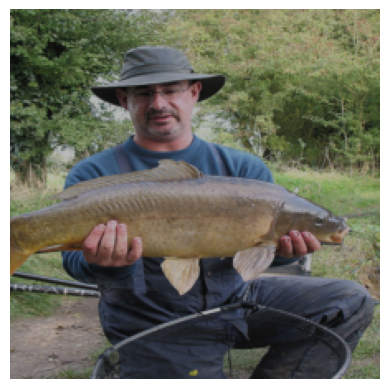

In [8]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import timm


# 从数据集中获取一张图像
data = next(iter(dataset_train))
image, label = data

# image
import matplotlib.pyplot as plt

# 将通道轴移动到最后一个位置 (224, 224, 3)
image = image.transpose(1, 2, 0)

plt.imshow(image)
plt.axis('off')  # 不显示坐标轴
plt.show()

In [9]:
# preprocess = transforms.Compose([
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
input = torch.Tensor(data[0]).unsqueeze(0).to(device)
input.shape # B, C, H, W

torch.Size([1, 3, 224, 224])

In [10]:
# model

In [11]:
# 获取模型输出
with torch.no_grad():
    output = model(input)

output.shape


torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])
torch.Size([1, 197, 384])


/home/fish/anaconda3/envs/timm/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 1000])

以这张图片为例，输入的一个 batch 的图片会在模型中先经过 patchembed 层，变成 （B，N，C）的形状，其中 B 为 batch size，N 为 patch 的个数，C 为每个 patch 的维度，这里为 384。
然后进入 transformer blocks, 一共有 12 个 transformer blocks，每个 transformer block 有两个 sublayers，一个是 multi-head self-attention，一个是 feedforward network。
这里的 multi-head self-attention 的输入是 （B，N，C），输出也是 （B，N，C），feedforward network 的输入是 （B，N，C），输出也是 （B，N，C）。这里的 N 为 196，C 为 384。
最后经过一个 layer norm，输出 （B，N，C），然后经过一个全连接层，输出 （B，1000），最后经过一个 softmax，输出 （B，1000）的概率分布。
```

In [12]:
# model

原文从 attn head，mlp demension 和 token dimension 三个方面进行了冗余调整，对于前两个维度，我们可以在训练的时候通过新建 model，然后复制权重来实现。对于 token 维度，可能需要重写类，加一个简单的参数。

文中可用的 baseline 是 deit s，里面 6 头每头的维度是 64，mlp 的维度是 4 × 384。我们可以这样设计：

首先，输入为 patchembed 之后的 (batchsize，196,384)

在 qkv 层，它乘以 qkv 的权重（384,384×3），变成 196, 384*3, 然后q,k,v,每个矩阵（384）按 head 分成 6 份 64。

矩阵就是 （batchsize, N_tokens 196, q+k+v 3, head 6, head_dim 64）

计算 attention score 之后，再乘一个 proj 矩阵（384×384），整理回到 （196,384）

按照论文的思想，我们需要调整 head 数量和权重矩阵激活的维度，所以我们可以这样设计：

在 qkv 乘，激活的头减少，qkv 的维度也减小，比如说激活两个头，qkv 激活四分之一，那么乘的结果就是 (196,3,2,16),proj 要改成本来 12 分之一。

这里也可以看出论文公式似乎存在小问题。

要满足这样的设计，最好的就是把 qkv 改改，不作为一个 linear 了，不然不方便。刚好 token 也要改，我们可以新弄一个类。

进一步考虑，qkv 还是不修改，保证模型基本一致，就是在参数复制的时候复杂点。

In [13]:
# @register_model
# def deit_tiny_patch16_224(pretrained=False, **kwargs) -> VisionTransformer:
#     """ DeiT-tiny model @ 224x224 from paper (https://arxiv.org/abs/2012.12877).
#     ImageNet-1k weights from https://github.com/facebookresearch/deit.
#     """
#     model_args = dict(patch_size=16, embed_dim=192, depth=12, num_heads=3)
#     model = _create_deit('deit_tiny_patch16_224', pretrained=pretrained, **dict(model_args, **kwargs))
#     return model


# @register_model
# def deit_small_patch16_224(pretrained=False, **kwargs) -> VisionTransformer:
#     """ DeiT-small model @ 224x224 from paper (https://arxiv.org/abs/2012.12877).
#     ImageNet-1k weights from https://github.com/facebookresearch/deit.
#     """
#     model_args = dict(patch_size=16, embed_dim=384, depth=12, num_heads=6)
#     model = _create_deit('deit_small_patch16_224', pretrained=pretrained, **dict(model_args, **kwargs))
#     return model


# @register_model
# def deit_base_patch16_224(pretrained=False, **kwargs) -> VisionTransformer:
#     """ DeiT base model @ 224x224 from paper (https://arxiv.org/abs/2012.12877).
#     ImageNet-1k weights from https://github.com/facebookresearch/deit.
#     """
#     model_args = dict(patch_size=16, embed_dim=768, depth=12, num_heads=12)
#     model = _create_deit('deit_base_patch16_224', pretrained=pretrained, **dict(model_args, **kwargs))
#     return model

下面的代码，我们可以进一步看一下具体的 attention 的计算过程，

In [14]:
# class Attention(nn.Module):
#     fused_attn: Final[bool]

#     def __init__(
#             self,
#             dim,
#             num_heads=8,
#             qkv_bias=False,
#             qk_norm=False,
#             attn_drop=0.,
#             proj_drop=0.,
#             norm_layer=nn.LayerNorm,
#     ):
#         super().__init__()
#         assert dim % num_heads == 0, 'dim should be divisible by num_heads'
#         self.num_heads = num_heads
#         self.head_dim = dim // num_heads
#         self.scale = self.head_dim ** -0.5
#         self.fused_attn = use_fused_attn()

#         self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
#         self.q_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
#         self.k_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
#         self.attn_drop = nn.Dropout(attn_drop)
#         self.proj = nn.Linear(dim, dim)
#         self.proj_drop = nn.Dropout(proj_drop)

#     def forward(self, x):
#         B, N, C = x.shape
#         qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
#         q, k, v = qkv.unbind(0)
#         q, k = self.q_norm(q), self.k_norm(k)

#         if self.fused_attn:
#             x = F.scaled_dot_product_attention(
#                 q, k, v,
#                 dropout_p=self.attn_drop.p,
#             )
#         else:
#             q = q * self.scale
#             attn = q @ k.transpose(-2, -1)
#             attn = attn.softmax(dim=-1)
#             attn = self.attn_drop(attn)
#             x = attn @ v

#         x = x.transpose(1, 2).reshape(B, N, C)
#         x = self.proj(x)
#         x = self.proj_drop(x)
#         return x


接下来进行改动，我们应该基于 deit 的模板。不宜在 model 内部进行 stage 切换，应该通过新建 model 的形式来完成。至于 qkv 参数怎么改，可以进一步考虑。

在 models 下，我们新建一类 bud.py， 表示我们新建的模型。

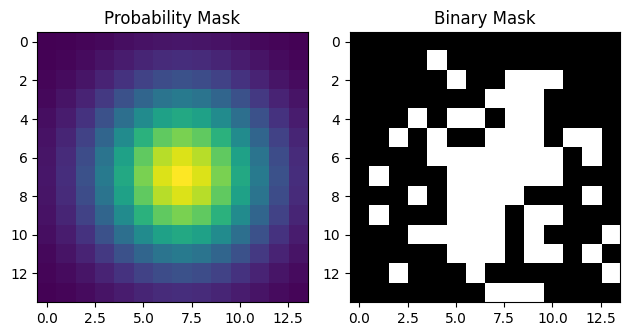

torch.Size([128, 196])

In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def generate_gaussian_mask(size, sigma):
    center = size // 2
    x, y = torch.meshgrid(torch.arange(size), torch.arange(size))
    mask = torch.exp(-((x - center)**2 + (y - center)**2) / (2 * sigma**2))
    mask = mask / mask.max()  # Normalize to [0, 1]
    return mask

def generate_batch_masks(batch_size, size, sigma):
    probability_masks = torch.stack([generate_gaussian_mask(size, sigma) for _ in range(batch_size)])
    binary_masks = torch.bernoulli(probability_masks)
    return probability_masks, binary_masks

batch_size = 128
size = 14
sigma = 3.0
probability_masks, binary_masks = generate_batch_masks(batch_size, size, sigma)

# Visualization for one mask in the batch
plt.subplot(1, 2, 1)
plt.imshow(probability_masks[0], cmap='viridis')
plt.title('Probability Mask')

plt.subplot(1, 2, 2)
plt.imshow(binary_masks[0], cmap='gray')
plt.title('Binary Mask')

plt.tight_layout()
plt.show()
binary_masks.view(batch_size,-1).shape

Text(0.5, 1.0, 'masked')

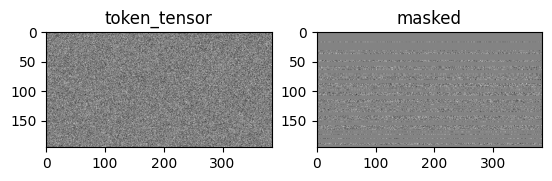

In [16]:
token_tensor = torch.randn(batch_size, 196, 384)
masked_token_tensor = token_tensor * binary_masks.view(batch_size,-1).unsqueeze(-1)
masked_token_tensor.shape

plt.subplot(1, 2, 1)
plt.imshow(token_tensor[0], cmap='gray')
plt.title('token_tensor')

plt.subplot(1, 2, 2)
plt.imshow(masked_token_tensor[0], cmap='gray')
plt.title('masked')

上面的代码中，我们写好了对应的 mask，我们需要把这个功能加入一个新写的 block 里面。这需要我们进入 timm 的 models 中进行修改，然后回到这个笔记的开头测试。

我们最终改好了一个 block 函数，它会按照 mlp ratio = 1,2,4 设置对应的 stage。

现在我们做好了一个 baby 模型，需要开始处理 stage 转换的部分。在转换中，我们理论上要把模型新建的内容重新跑一遍。

In [17]:
# model

In [95]:
args.model

'bud_small_patch16_224_child'

In [96]:
    old_model = model
    old_optimizer = optimizer
    old_loss_scaler = loss_scaler
    old_lr_scheduler = lr_scheduler
    if args.use_eva:
        old_preconditioner = preconditioner

    # args.model = args.model.replace('baby', 'child')
    args.model = args.model.replace('child', 'man')
    # args.model = args.model.replace('man', 'baby')
    model = create_model(
        args.model,
        pretrained=args.pretrained,
        in_chans=in_chans,
        num_classes=args.num_classes,
        drop_rate=args.drop,
        drop_path_rate=args.drop_path,
        drop_block_rate=args.drop_block,
        global_pool=args.gp,
        bn_momentum=args.bn_momentum,
        bn_eps=args.bn_eps,
        scriptable=args.torchscript,
        checkpoint_path=args.initial_checkpoint,
        **args.model_kwargs,
    )
    if args.head_init_scale is not None:
        with torch.no_grad():
            model.get_classifier().weight.mul_(args.head_init_scale)
            model.get_classifier().bias.mul_(args.head_init_scale)
    if args.head_init_bias is not None:
        nn.init.constant_(model.get_classifier().bias, args.head_init_bias)

    if args.num_classes is None:
        assert hasattr(model, 'num_classes'), 'Model must have `num_classes` attr if not set on cmd line/config.'
        args.num_classes = model.num_classes  # FIXME handle model default vs config num_classes more elegantly

    if args.grad_checkpointing:
        model.set_grad_checkpointing(enable=True)

    if utils.is_primary(args):
        _logger.info(
            f'Model {safe_model_name(args.model)} created, param count:{sum([m.numel() for m in model.parameters()])}')

    data_config = resolve_data_config(vars(args), model=model, verbose=utils.is_primary(args))

    # setup augmentation batch splits for contrastive loss or split bn
    num_aug_splits = 0
    if args.aug_splits > 0:
        assert args.aug_splits > 1, 'A split of 1 makes no sense'
        num_aug_splits = args.aug_splits

    # enable split bn (separate bn stats per batch-portion)
    if args.split_bn:
        assert num_aug_splits > 1 or args.resplit
        model = convert_splitbn_model(model, max(num_aug_splits, 2))

    # move model to GPU, enable channels last layout if set
    model.to(device=device)
    if args.channels_last:
        model.to(memory_format=torch.channels_last)

    # setup synchronized BatchNorm for distributed training
    if args.distributed and args.sync_bn:
        args.dist_bn = ''  # disable dist_bn when sync BN active
        assert not args.split_bn
        if has_apex and use_amp == 'apex':
            # Apex SyncBN used with Apex AMP
            # WARNING this won't currently work with models using BatchNormAct2d
            model = convert_syncbn_model(model)
        else:
            model = convert_sync_batchnorm(model)
        if utils.is_primary(args):
            _logger.info(
                'Converted model to use Synchronized BatchNorm. WARNING: You may have issues if using '
                'zero initialized BN layers (enabled by default for ResNets) while sync-bn enabled.')

    if args.torchscript:
        assert not args.torchcompile
        assert not use_amp == 'apex', 'Cannot use APEX AMP with torchscripted model'
        assert not args.sync_bn, 'Cannot use SyncBatchNorm with torchscripted model'
        model = torch.jit.script(model)

    if not args.lr:
        global_batch_size = args.batch_size * args.world_size * args.grad_accum_steps
        batch_ratio = global_batch_size / args.lr_base_size
        if not args.lr_base_scale:
            on = args.opt.lower()
            args.lr_base_scale = 'sqrt' if any([o in on for o in ('ada', 'lamb')]) else 'linear'
        if args.lr_base_scale == 'sqrt':
            batch_ratio = batch_ratio ** 0.5
        args.lr = args.lr_base * batch_ratio
        if utils.is_primary(args):
            _logger.info(
                f'Learning rate ({args.lr}) calculated from base learning rate ({args.lr_base}) '
                f'and effective global batch size ({global_batch_size}) with {args.lr_base_scale} scaling.')

    optimizer = create_optimizer_v2(
        model,
        **optimizer_kwargs(cfg=args),
        **args.opt_kwargs,
    )

    # fish: add eva preconditioner, not sure if to use model without ddp
    if args.use_eva:
        
        # preconditioner = Eva(model_without_ddp)
        preconditioner = Eva(
                model, lr=args.lr, factor_decay=args.stat_decay,
                damping=args.damping, kl_clip=args.kl_clip,
                fac_update_freq=args.kfac_cov_update_freq,
                kfac_update_freq=args.kfac_update_freq,
                #diag_blocks=args.diag_blocks,
                #diag_warmup=args.diag_warmup,
                #distribute_layer_factors=args.distribute_layer_factors, 
                exclude_parts=args.exclude_parts)

        kfac_param_scheduler = KFACParamScheduler(
               preconditioner,
               damping_alpha=args.damping_alpha,
               damping_schedule=args.damping_decay,
               update_freq_alpha=args.kfac_update_freq_alpha,
               update_freq_schedule=args.kfac_update_freq_decay,
               start_epoch=args.start_epoch)

        print(f"preconditioner eva is adapted")

    else:
        preconditioner = None

    # setup automatic mixed-precision (AMP) loss scaling and op casting
    amp_autocast = suppress  # do nothing
    loss_scaler = None
    if use_amp == 'apex':
        assert device.type == 'cuda'
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1')
        loss_scaler = ApexScaler()
        if utils.is_primary(args):
            _logger.info('Using NVIDIA APEX AMP. Training in mixed precision.')
    elif use_amp == 'native':
        try:
            amp_autocast = partial(torch.autocast, device_type=device.type, dtype=amp_dtype)
        except (AttributeError, TypeError):
            # fallback to CUDA only AMP for PyTorch < 1.10
            assert device.type == 'cuda'
            amp_autocast = torch.cuda.amp.autocast
        if device.type == 'cuda' and amp_dtype == torch.float16:
            # loss scaler only used for float16 (half) dtype, bfloat16 does not need it
            loss_scaler = NativeScaler()
        if utils.is_primary(args):
            _logger.info('Using native Torch AMP. Training in mixed precision.')
    else:
        if utils.is_primary(args):
            _logger.info('AMP not enabled. Training in float32.')

    # optionally resume from a checkpoint
    resume_epoch = None
    if args.resume:
        resume_epoch = resume_checkpoint(
            model,
            args.resume,
            optimizer=None if args.no_resume_opt else optimizer,
            loss_scaler=None if args.no_resume_opt else loss_scaler,
            log_info=utils.is_primary(args),
        )

    # setup exponential moving average of model weights, SWA could be used here too
    model_ema = None
    if args.model_ema:
        # Important to create EMA model after cuda(), DP wrapper, and AMP but before DDP wrapper
        model_ema = utils.ModelEmaV2(
            model, decay=args.model_ema_decay, device='cpu' if args.model_ema_force_cpu else None)
        if args.resume:
            load_checkpoint(model_ema.module, args.resume, use_ema=True)

    # setup distributed training
    if args.distributed:
        if has_apex and use_amp == 'apex':
            # Apex DDP preferred unless native amp is activated
            if utils.is_primary(args):
                _logger.info("Using NVIDIA APEX DistributedDataParallel.")
            model = ApexDDP(model, delay_allreduce=True)
        else:
            if utils.is_primary(args):
                _logger.info("Using native Torch DistributedDataParallel.")
            model = NativeDDP(model, device_ids=[device], broadcast_buffers=not args.no_ddp_bb)
        # NOTE: EMA model does not need to be wrapped by DDP

    if args.torchcompile:
        # torch compile should be done after DDP
        assert has_compile, 'A version of torch w/ torch.compile() is required for --compile, possibly a nightly.'
        model = torch.compile(model, backend=args.torchcompile)

    # setup mixup / cutmix
    collate_fn = None
    mixup_fn = None
    mixup_active = args.mixup > 0 or args.cutmix > 0. or args.cutmix_minmax is not None
    if mixup_active:
        mixup_args = dict(
            mixup_alpha=args.mixup,
            cutmix_alpha=args.cutmix,
            cutmix_minmax=args.cutmix_minmax,
            prob=args.mixup_prob,
            switch_prob=args.mixup_switch_prob,
            mode=args.mixup_mode,
            label_smoothing=args.smoothing,
            num_classes=args.num_classes
        )
        if args.prefetcher:
            assert not num_aug_splits  # collate conflict (need to support deinterleaving in collate mixup)
            collate_fn = FastCollateMixup(**mixup_args)
        else:
            mixup_fn = Mixup(**mixup_args)

    # wrap dataset in AugMix helper
    if num_aug_splits > 1:
        dataset_train = AugMixDataset(dataset_train, num_splits=num_aug_splits)

    # create data loaders w/ augmentation pipeiine
    train_interpolation = args.train_interpolation
    if args.no_aug or not train_interpolation:
        train_interpolation = data_config['interpolation']

    # setup loss function
    if args.jsd_loss:
        assert num_aug_splits > 1  # JSD only valid with aug splits set
        train_loss_fn = JsdCrossEntropy(num_splits=num_aug_splits, smoothing=args.smoothing)
    elif mixup_active:
        # smoothing is handled with mixup target transform which outputs sparse, soft targets
        if args.bce_loss:
            train_loss_fn = BinaryCrossEntropy(target_threshold=args.bce_target_thresh)
        else:
            train_loss_fn = SoftTargetCrossEntropy()
    elif args.smoothing:
        if args.bce_loss:
            train_loss_fn = BinaryCrossEntropy(smoothing=args.smoothing, target_threshold=args.bce_target_thresh)
        else:
            train_loss_fn = LabelSmoothingCrossEntropy(smoothing=args.smoothing)
    else:
        train_loss_fn = nn.CrossEntropyLoss()
    train_loss_fn = train_loss_fn.to(device=device)
    validate_loss_fn = nn.CrossEntropyLoss().to(device=device)

    # setup checkpoint saver and eval metric tracking
    eval_metric = args.eval_metric
    best_metric = None
    best_epoch = None
    saver = None
    output_dir = None
    if utils.is_primary(args):
        if args.experiment:
            exp_name = args.experiment
        else:
            exp_name = '-'.join([
                datetime.now().strftime("%Y%m%d-%H%M%S"),
                safe_model_name(args.model),
                str(data_config['input_size'][-1])
            ])
        output_dir = utils.get_outdir(args.output if args.output else './output/train', exp_name)
        decreasing = True if eval_metric == 'loss' else False
        saver = utils.CheckpointSaver(
            model=model,
            optimizer=optimizer,
            args=args,
            model_ema=model_ema,
            amp_scaler=loss_scaler,
            checkpoint_dir=output_dir,
            recovery_dir=output_dir,
            decreasing=decreasing,
            max_history=args.checkpoint_hist
        )
        with open(os.path.join(output_dir, 'args.yaml'), 'w') as f:
            f.write(args_text)

    if utils.is_primary(args) and args.log_wandb:
        if has_wandb:
            wandb.init(project='timm',name=args.experiment, config=args)
        else:
            _logger.warning(
                "You've requested to log metrics to wandb but package not found. "
                "Metrics not being logged to wandb, try `pip install wandb`")

    # setup learning rate schedule and starting epoch
    updates_per_epoch = (len(loader_train) + args.grad_accum_steps - 1) // args.grad_accum_steps
    lr_scheduler, num_epochs = create_scheduler_v2(
        optimizer,
        **scheduler_kwargs(args),
        updates_per_epoch=updates_per_epoch,
    )
    start_epoch = 0
    if args.start_epoch is not None:
        # a specified start_epoch will always override the resume epoch
        start_epoch = args.start_epoch
    elif resume_epoch is not None:
        start_epoch = resume_epoch
    if lr_scheduler is not None and start_epoch > 0:
        if args.sched_on_updates:
            lr_scheduler.step_update(start_epoch * updates_per_epoch)
        else:
            lr_scheduler.step(start_epoch)

    if utils.is_primary(args):
        _logger.info(
            f'Scheduled epochs: {num_epochs}. LR stepped per {"epoch" if lr_scheduler.t_in_epochs else "update"}.')

Model bud_small_patch16_224_man created, param count:22050664
Data processing configuration for current model + dataset:
	input_size: (3, 224, 224)
	interpolation: bicubic
	mean: (0.485, 0.456, 0.406)
	std: (0.229, 0.224, 0.225)
	crop_pct: 0.9
	crop_mode: center
Using native Torch AMP. Training in mixed precision.
Scheduled epochs: 3. LR stepped per epoch.


接下来我们测试如何转移模型参数。从模型结构中可以看到要转移的有：
 - blocks 中，每个 block 的
   - attention 的 qkv 的权重

In [97]:
old_model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): BudgetedBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): BudgetedAttention(
        (qkv): Linear(in_features=384, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (no

已经有了新旧两个模型，我们需要尝试迁移模型参数和optimizer中的参数。我们知道下面这段可以打印出模型的参数，

```python
for param_tensor in model.state_dict(): # 字典的遍历默认是遍历 key，所以param_tensor实际上是键值
    print(param_tensor,'\t',model.state_dict()[param_tensor].size())
```

而在我们的设定中，我们需要将新模型中的参数替换为旧模型中的参数，所以我们需要将新模型的参数名和旧模型的参数名对应起来。这里我们可以使用`model.state_dict().keys()`来获取新模型的参数名，使用`old_model.state_dict().keys()`来获取旧模型的参数名，然后使用`zip()`函数将两个参数名对应起来，最后使用`dict()`函数将其转换为字典。这样我们就可以通过`new_model.load_state_dict(old_model.state_dict())`来将旧模型的参数复制到新模型中了。

（copilot 说的，可能能用上）

In [80]:
a = torch.Size([10,20])
len(a)

2

In [147]:
print(model.state_dict()['blocks.0.attn.qkv.weight'])
print(old_model.state_dict()['blocks.0.attn.qkv.weight'])
# try:
#     model.state_dict()['blocks.0.attn.qkv.weight'] = old_model.state_dict()['blocks.0.attn.qkv.weight']
# except:
#     print('error')
# print(model.state_dict()['blocks.0.attn.qkv.weight'].size()) #torch.Size([576, 384])

# with torch.no_grad():
#     tmp = old_model.state_dict()['blocks.0.attn.qkv.weight']
#     print(tmp.size())
#     # expand tmp to 576, 384
#     tmp =  torch.cat((tmp, tmp), 0)
#     print(tmp.size())
#     print(tmp)
#     # model.state_dict()['blocks.0.attn.qkv.weight'].load(tmp)
#     # model.state_dict()['blocks.0.attn.qkv.weight'] = tmp
#     model.state_dict().update(tmp)
#     print(model.state_dict()['blocks.0.attn.qkv.weight'])

# with torch.no_grad():
#     tmp = old_model.state_dict()
#     print(tmp['blocks.0.attn.qkv.weight'].size())
#     tmp['blocks.0.attn.qkv.weight'] = torch.cat((tmp['blocks.0.attn.qkv.weight'], tmp['blocks.0.attn.qkv.weight']), 0)
    
#     # expand tmp to 576, 384
#     # tmp =  torch.cat((tmp, tmp), 0)
#     print(tmp['blocks.0.attn.qkv.weight'].size())
#     print(tmp['blocks.0.attn.qkv.weight'])
#     # model.state_dict()['blocks.0.attn.qkv.weight'].load(tmp)
#     # model.state_dict()['blocks.0.attn.qkv.weight'] = tmp
#     dst = model.state_dict()
#     dst.update(tmp)
#     print(dst['blocks.0.attn.qkv.weight'])
#     model.load_state_dict(dst, strict=False)
#     print(model.state_dict()['blocks.0.attn.qkv.weight'])

with torch.no_grad():
    tmp = old_model.state_dict()
    for param_tensor in old_model.state_dict(): # 字典的遍历默认是遍历 key，所以param_tensor实际上是键值
        # print(param_tensor,'\t',model.state_dict()[param_tensor].size())
        old_size = old_model.state_dict()[param_tensor].size()
        new_size = model.state_dict()[param_tensor].size()
        flag = False
        if len(old_size) != len(new_size):
            continue
        elif len(old_size) == 1:
            # 如果整除
            if new_size[0] % old_size[0] == 0:
                times = new_size[0] // old_size[0]
                tmp[param_tensor] = torch.cat((tmp[param_tensor],)*times, 0)
            # if old_size[0]*2 == new_size[0]:
            #     tmp[param_tensor] = torch.cat((tmp[param_tensor], tmp[param_tensor]), 0)
                flag = True
            # 如果是 2:3
            elif old_size[0]*3 == new_size[0]*2:
                # 拼接tensor和它自己的一半
                if old_size[0] % 2 == 0:
                    tmp[param_tensor] = torch.cat((tmp[param_tensor],tmp[param_tensor][:old_size[0]//2]), 0)
                    # tmp[param_tensor] = torch.cat((tmp[param_tensor],tmp[param_tensor][]), 0)
                    flag = True
                else:
                    # 未实现
                    print('error')
        elif len(old_size) == 2:
            if old_size[0] == new_size[0]:
                # if old_size[1]*2 == new_size[1]:
                if new_size[1] % old_size[1] == 0:
                    times = new_size[1] // old_size[1]
                    tmp[param_tensor] = torch.cat((tmp[param_tensor],)*times, 1)
                    flag = True
                elif old_size[1]*3 == new_size[1]*2:
                    if old_size[1] % 2 == 0:
                        tmp[param_tensor] = torch.cat((tmp[param_tensor],tmp[param_tensor][:,old_size[1]//2]), 1)
                        flag = True
                    else:
                        # 未实现
                        print('error')
            elif old_size[1] == new_size[1]:
                # if old_size[0]*2 == new_size[0]:
                if new_size[0] % old_size[0] == 0:
                    times = new_size[0] // old_size[0]
                    tmp[param_tensor] = torch.cat((tmp[param_tensor],)*times, 0)
                    flag = True
                elif old_size[0]*3 == new_size[0]*2:    
                    if old_size[0] % 2 == 0:
                        tmp[param_tensor] = torch.cat((tmp[param_tensor],tmp[param_tensor][:old_size[0]//2]), 0)
                        flag = True
                    else:
                        # 未实现
                        print('error')
        if not flag:
            if param_tensor in model.state_dict():
                tmp[param_tensor] = model.state_dict()[param_tensor]
            else:
                continue
    model.load_state_dict(tmp, strict=False)
    print(model.state_dict()['blocks.0.attn.qkv.weight'])

tensor([[-0.0305,  0.0021,  0.0017,  ...,  0.0108, -0.0061, -0.0448],
        [ 0.0169,  0.0041,  0.0204,  ...,  0.0027, -0.0221,  0.0111],
        [-0.0011,  0.0136, -0.0130,  ...,  0.0104,  0.0156, -0.0249],
        ...,
        [ 0.0108, -0.0009, -0.0166,  ...,  0.0091,  0.0136, -0.0096],
        [ 0.0079, -0.0130,  0.0135,  ...,  0.0322, -0.0220, -0.0219],
        [ 0.0368, -0.0042,  0.0287,  ..., -0.0283, -0.0063, -0.0173]],
       device='cuda:0')
tensor([[-0.0305,  0.0021,  0.0017,  ...,  0.0108, -0.0061, -0.0448],
        [ 0.0169,  0.0041,  0.0204,  ...,  0.0027, -0.0221,  0.0111],
        [-0.0011,  0.0136, -0.0130,  ...,  0.0104,  0.0156, -0.0249],
        ...,
        [ 0.0108, -0.0009, -0.0166,  ...,  0.0091,  0.0136, -0.0096],
        [ 0.0079, -0.0130,  0.0135,  ...,  0.0322, -0.0220, -0.0219],
        [ 0.0368, -0.0042,  0.0287,  ..., -0.0283, -0.0063, -0.0173]],
       device='cuda:0')
tensor([[-0.0305,  0.0021,  0.0017,  ...,  0.0108, -0.0061, -0.0448],
        [ 0.01

In [82]:
for param_tensor in model.state_dict():
    # print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    if param_tensor in old_model.state_dict().keys():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size(), "\t", old_model.state_dict()[param_tensor].size())
        model.state_dict()[param_tensor] = old_model.state_dict()[param_tensor]
        # print(param_tensor, "\t", model.state_dict()[param_tensor].size(), "\t", old_model[param_tensor].size())

cls_token 	 torch.Size([1, 1, 384]) 	 torch.Size([1, 1, 384])
pos_embed 	 torch.Size([1, 197, 384]) 	 torch.Size([1, 197, 384])
patch_embed.proj.weight 	 torch.Size([384, 3, 16, 16]) 	 torch.Size([384, 3, 16, 16])
patch_embed.proj.bias 	 torch.Size([384]) 	 torch.Size([384])
blocks.0.norm1.weight 	 torch.Size([384]) 	 torch.Size([384])
blocks.0.norm1.bias 	 torch.Size([384]) 	 torch.Size([384])
blocks.0.attn.qkv.weight 	 torch.Size([576, 384]) 	 torch.Size([288, 384])
blocks.0.attn.qkv.bias 	 torch.Size([576]) 	 torch.Size([288])
blocks.0.attn.proj.weight 	 torch.Size([384, 192]) 	 torch.Size([384, 96])
blocks.0.attn.proj.bias 	 torch.Size([384]) 	 torch.Size([384])
blocks.0.norm2.weight 	 torch.Size([384]) 	 torch.Size([384])
blocks.0.norm2.bias 	 torch.Size([384]) 	 torch.Size([384])
blocks.0.mlp.fc1.weight 	 torch.Size([768, 384]) 	 torch.Size([384, 384])
blocks.0.mlp.fc1.bias 	 torch.Size([768]) 	 torch.Size([384])
blocks.0.mlp.fc2.weight 	 torch.Size([384, 768]) 	 torch.Size([384,

In [144]:
old_optimizer.param_groups[0]['params']

Lion (
Parameter Group 0
    betas: (0.9, 0.99)
    foreach: True
    initial_lr: 5e-05
    lr: 5e-05
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    betas: (0.9, 0.99)
    foreach: True
    initial_lr: 5e-05
    lr: 5e-05
    maximize: False
    weight_decay: 0.001
)

In [162]:
old_p

Parameter containing:
tensor([[-0.0217,  0.0011,  0.0443,  ...,  0.0183, -0.0095, -0.0286],
        [ 0.0119, -0.0074, -0.0218,  ..., -0.0382, -0.0525,  0.0229],
        [-0.0086,  0.0219,  0.0173,  ..., -0.0027,  0.0130, -0.0091],
        ...,
        [ 0.0457,  0.0076, -0.0350,  ...,  0.0143,  0.0123, -0.0027],
        [ 0.0090,  0.0228, -0.0129,  ..., -0.0273, -0.0003,  0.0221],
        [ 0.0106, -0.0169,  0.0364,  ...,  0.0139, -0.0125,  0.0196]],
       device='cuda:0', requires_grad=True)

In [163]:
new_p

Parameter containing:
tensor([[-0.0217,  0.0011,  0.0443,  ...,  0.0183, -0.0095, -0.0286],
        [ 0.0119, -0.0074, -0.0218,  ..., -0.0382, -0.0525,  0.0229],
        [-0.0086,  0.0219,  0.0173,  ..., -0.0027,  0.0130, -0.0091],
        ...,
        [ 0.0457,  0.0076, -0.0350,  ...,  0.0143,  0.0123, -0.0027],
        [ 0.0090,  0.0228, -0.0129,  ..., -0.0273, -0.0003,  0.0221],
        [ 0.0106, -0.0169,  0.0364,  ...,  0.0139, -0.0125,  0.0196]],
       device='cuda:0', requires_grad=True)

In [168]:
a = torch.zeros(2,3)
b = torch.ones(4,4)
b[:a.shape[0],:a.shape[1]] = a
b

tensor([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [161]:
len(old_optimizer.param_groups[0]['params'])
# 接下来，遍历原始模型的参数，把他们加入新的优化器中
for param_group in range(len(old_optimizer.param_groups)):
    for i, (old_p, new_p) in enumerate(zip(old_optimizer.param_groups[param_group]['params'], optimizer.param_groups[param_group]['params'])):
        # 查看 old_p 和 new_p 的 shape
        print(old_p.shape, new_p.shape)
        with torch.no_grad():
            if old_p.shape == new_p.shape:
                new_p = old_p
            else:
                # 否则，用 0 填补 new_p 的后半部分
                # 如果 new_p 是 1 维
                if len(new_p.shape) == 1:
                    new_p[:old_p.shape[0]] = old_p
                # 如果 new_p 是 2 维
                elif len(new_p.shape) == 2:
                    new_p[:old_p.shape[0], :old_p.shape[1]] = old_p

torch.Size([1, 1, 384]) torch.Size([1, 1, 384])
torch.Size([1, 197, 384]) torch.Size([1, 197, 384])
torch.Size([384]) torch.Size([384])
torch.Size([384]) torch.Size([384])
torch.Size([384]) torch.Size([384])
torch.Size([576]) torch.Size([1152])
torch.Size([384]) torch.Size([384])
torch.Size([384]) torch.Size([384])
torch.Size([384]) torch.Size([384])
torch.Size([768]) torch.Size([1536])
torch.Size([384]) torch.Size([384])
torch.Size([384]) torch.Size([384])
torch.Size([384]) torch.Size([384])
torch.Size([576]) torch.Size([1152])
torch.Size([384]) torch.Size([384])
torch.Size([384]) torch.Size([384])
torch.Size([384]) torch.Size([384])
torch.Size([768]) torch.Size([1536])
torch.Size([384]) torch.Size([384])
torch.Size([384]) torch.Size([384])
torch.Size([384]) torch.Size([384])
torch.Size([576]) torch.Size([1152])
torch.Size([384]) torch.Size([384])
torch.Size([384]) torch.Size([384])
torch.Size([384]) torch.Size([384])
torch.Size([768]) torch.Size([1536])
torch.Size([384]) torch.Size([